Simulate Discrete Data from Causal Bayesian Network
===================================================

In many real-world settings, domain knowledge or some oracle is able to provide us with a hypothesized causal DAG, which is a core ingredient to perform causal reasoning and inference. However, certain algorithms, such as causal discovery algorithms, or causal estimation algorithms need to be evaluated with data. Thus, one would like ground-truth data that we know is generated from the causal graphical model. 

In this example, we demonstrate how we can setup and construct a causal graph and then sample discrete data from it after it is parametrized by conditional probability tables (CPT) that represent conditional probability
distributions of each of the variables given its parents.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext lab_black

In [138]:
from pywhy_graphs.viz import draw
from pywhy_graphs.functional.discrete import make_random_discrete_graph
from pywhy_graphs.functional import sample_from_graph

import scipy.stats
import networkx as nx
import numpy as np
import pandas as pd
import bnlearn

from dodiscover.ci import GSquareCITest, Oracle, CategoricalCITest
from dodiscover import PC, make_context

In [4]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.factors.discrete import JointProbabilityDistribution


def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [5]:
n_jobs = -1

Draw a graph
------------

In this example, we want to setup a very simple graph.

In [18]:
edge_list = [
    ("A", "B"),
    ("B", "C"),
    ("C", "D"),
    ("B", "D"),
    ("X", "A"),
    ("X", "C"),
    ("C", "W"),
]
G = nx.DiGraph()

G.add_edges_from(edge_list)

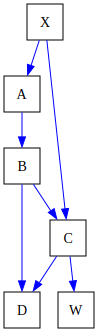

In [122]:
draw(G)

Define the distributions for nodes and functions for edges
----------------------------------------------------------

Now, we can parametrize the graph fully, so that sampling from it is possible.

In [300]:
cardinality_lims = {node: [2, 4] for node in G.nodes}
weight_lims = {node: [1, 100] for node in G.nodes}
noise_ratio_lims = {node: [0.1, 0.1] for node in G.nodes}
seed = 1234

In [301]:
print(cardinality_lims)

{'A': [2, 4], 'B': [2, 4], 'C': [2, 4], 'D': [2, 4], 'X': [2, 4], 'W': [2, 4]}


In [302]:
G = make_random_discrete_graph(
    G,
    cardinality_lims=cardinality_lims,
    weight_lims=weight_lims,
    noise_ratio_lims=noise_ratio_lims,
    random_state=seed,
    overwrite=True,
)

print(G)

DiGraph with 6 nodes and 7 edges


In [303]:
# we can extract the conditional probability table for each node, which is a function of its parents
node_dict = G.nodes["C"]

print_full(node_dict["cpd"])

+------+--------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| B    | B(0)               | B(0)                | B(0)               | B(1)                | B(1)                | B(1)               | B(2)                | B(2)                | B(2)                |
+------+--------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| X    | X(0)               | X(1)                | X(2)               | X(0)                | X(1)                | X(2)               | X(0)                | X(1)                | X(2)                |
+------+--------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---

In [319]:
# now we sample from the graph the discrete dataset
df = sample_from_graph(G, n_samples=20000, n_jobs=1, random_state=seed)

  0%|          | 0/6 [00:00<?, ?it/s]

In [320]:
display(df.head())
print(df.shape)

,A,B,C,D,W,X
0,1,2,2,1,0,1
1,2,2,0,2,0,2
2,1,2,2,1,0,1
3,0,1,1,0,0,2
4,2,1,2,2,1,2


(20000, 6)


In [321]:
ci_estimator = GSquareCITest(data_type="discrete")
ci_estimator = CategoricalCITest(lambda_="cressie-read")

In [322]:
context = make_context().variables(data=df).build()

pc = PC(
    ci_estimator=ci_estimator,
    n_jobs=n_jobs,
    max_cond_set_size=2,
    max_combinations=None,
    # alpha=0.5,
)
pc.fit(df, context)

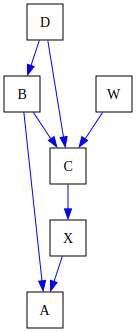

In [323]:
graph = pc.graph_
draw(graph)

In [331]:
from pgmpy.utils import get_example_model

model = get_example_model("cancer")
print("Nodes in the model:", model.nodes())
print("Edges in the model:", model.edges())
model.get_cpds()

Nodes in the model: ['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dyspnoea']
Edges in the model: [('Pollution', 'Cancer'), ('Smoker', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea')]


[<TabularCPD representing P(Cancer:2 | Pollution:2, Smoker:2) at 0x29831f070>,
 <TabularCPD representing P(Dyspnoea:2 | Cancer:2) at 0x2983275b0>,
 <TabularCPD representing P(Pollution:2) at 0x29831f340>,
 <TabularCPD representing P(Smoker:2) at 0x2876ddbe0>,
 <TabularCPD representing P(Xray:2 | Cancer:2) at 0x29815f070>]

In [332]:
print(model)

BayesianNetwork named 'unknown' with 5 nodes and 4 edges


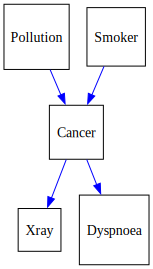

In [333]:
draw(model.to_directed())

In [334]:
from pgmpy.sampling import BayesianModelSampling

In [341]:
inference = BayesianModelSampling(model)
df = inference.forward_sample(size=10000)

  0%|          | 0/5 [00:00<?, ?it/s]

In [342]:
display(df.head())

,Pollution,Smoker,Cancer,Xray,Dyspnoea
0,high,False,False,negative,False
1,low,True,False,negative,True
2,low,False,False,negative,False
3,high,True,False,negative,False
4,low,False,False,negative,False


In [343]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])
    print(le.classes_)

display(df.head())

['high' 'low']
['False' 'True']
['False' 'True']
['negative' 'positive']
['False' 'True']


,Pollution,Smoker,Cancer,Xray,Dyspnoea
0,0,0,0,0,0
1,1,1,0,0,1
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [13]:
ci_estimator = GSquareCITest(data_type="binary")
ci_estimator = CategoricalCITest(lambda_="cressie-read")

In [14]:
# df.groupby(["Xray", "Cancer"])
list({"Xray"})

['Xray']

In [346]:
ci_estimator.test(df, {"Pollution"}, {"Smoker"}, {"Xray"})

(0.49687790616879024, 0.780017477042798)

In [347]:
context = make_context().variables(data=df).build()

pc = PC(ci_estimator=ci_estimator, n_jobs=n_jobs)
pc.fit(df, context)

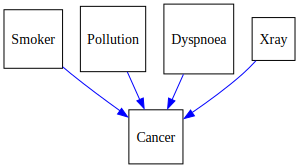

In [348]:
graph = pc.graph_

draw(graph)

In [338]:
from pgmpy.estimators import HillClimbSearch, BicScore

print(df.shape)

(5000, 5)


In [344]:
est = HillClimbSearch(df)
best_model = est.estimate(scoring_method=BicScore(df))

  0%|          | 0/1000000 [00:00<?, ?it/s]

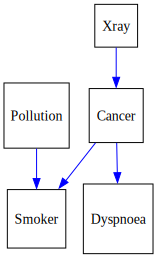

In [345]:
draw(best_model.to_directed())

In [351]:
sampled_data = np.random.standard_normal(size=(3, 3))
evidence = [0, 1]

print(sampled_data)

evidence_values = np.vstack([sampled_data[node] for node in evidence])
print(evidence_values)

[[ 1.15763797 -0.51495728  0.82813172]
 [ 0.81095629 -0.05694341  0.00330993]
 [-2.27230684 -0.48513568 -1.5987612 ]]
[[ 1.15763797 -0.51495728  0.82813172]
 [ 0.81095629 -0.05694341  0.00330993]]
